### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
#import autosklearn.classification as classifier

In [5]:
# !apt-get install swig -y
# %pip install Cython numpy
# %pip install auto-sklearn


### Load Dataset

In [2]:
df=pd.read_csv("D:/Machine Predictive Maintenance Classification Dataset/data/predictive_maintenance.csv")

In [3]:
df.head(5)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


### Data Profiling

In [4]:
df.shape

(10000, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [7]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [9]:
total_types=df.shape[0]
low_types=df[df["Type"]=="L"].shape[0]
medium_types=df[df["Type"]=="M"].shape[0]
high_types=df[df["Type"]=="H"].shape[0]

# Calculate percentages
low_percentage = (low_types / total_types) * 100
medium_percentage = (medium_types / total_types) * 100
high_percentage = (high_types / total_types) * 100

print("Low%:",low_percentage)
print("Medium%:",medium_percentage)
print("High%:",high_percentage)

Low%: 60.0
Medium%: 29.970000000000002
High%: 10.03


In [10]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Target', 'Failure Type'],
      dtype='object')

In [11]:
independent_variables=df.columns[3:8]
independent_variables

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'],
      dtype='object')

In [12]:
dependent_variables=df.columns[8:]
dependent_variables

Index(['Target', 'Failure Type'], dtype='object')

In [13]:
independent_variables[0]

'Air temperature [K]'

In [14]:
df['Target'].unique()

array([0, 1], dtype=int64)

In [15]:
df['Failure Type'].unique()

array(['No Failure', 'Power Failure', 'Tool Wear Failure',
       'Overstrain Failure', 'Random Failures',
       'Heat Dissipation Failure'], dtype=object)

In [16]:
for variable in dependent_variables:
    print(df[variable].value_counts())
    print("***"*8)

0    9661
1     339
Name: Target, dtype: int64
************************
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64
************************


### Exploratory data analysis

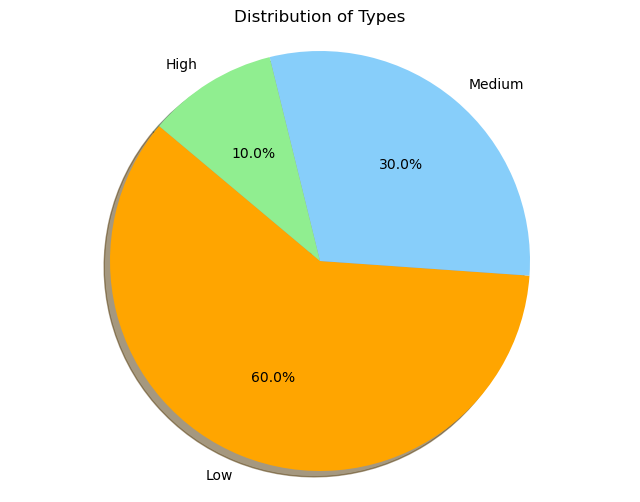

In [17]:
# Data to plot
sizes = [low_percentage, medium_percentage, high_percentage]
labels = ['Low', 'Medium', 'High']
colors = ['orange', 'lightskyblue', 'lightgreen']

# Plot
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Distribution of Types')

plt.show()


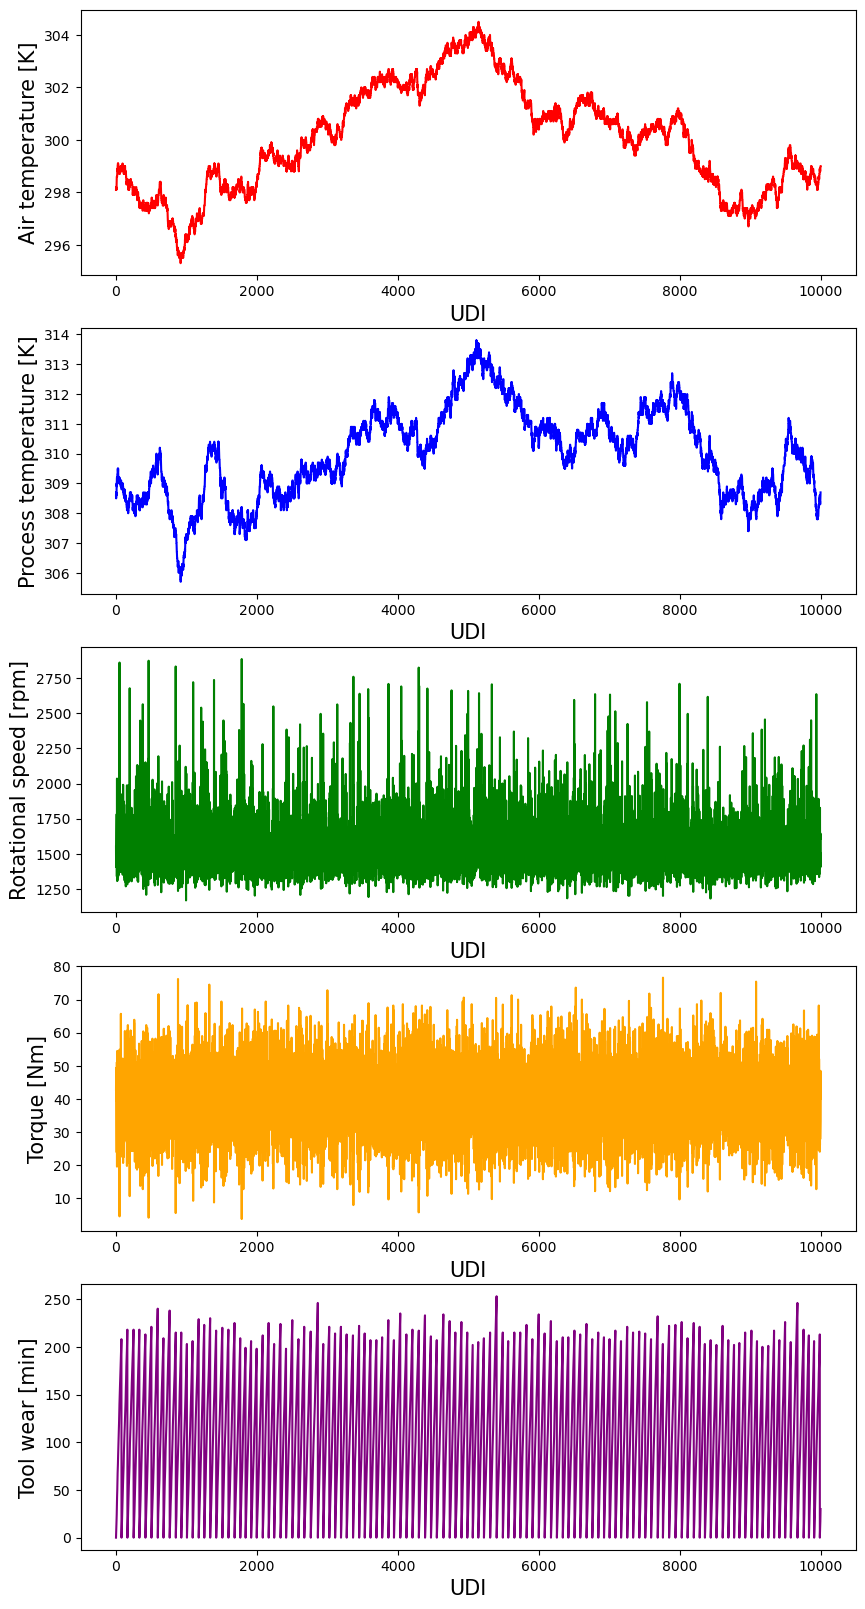

In [18]:
# Visualizing the trends of independent variables
fig, ax = plt.subplots(5,figsize=(10,20))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for i in range(5):
    ax[i].plot(df["UDI"],df[independent_variables[i]],color=colors[i])
    ax[i].set_xlabel("UDI",fontsize=15)
    ax[i].set_ylabel(independent_variables[i],fontsize=15)
    # ax[i].legend(independent_variables[i])
plt.show()

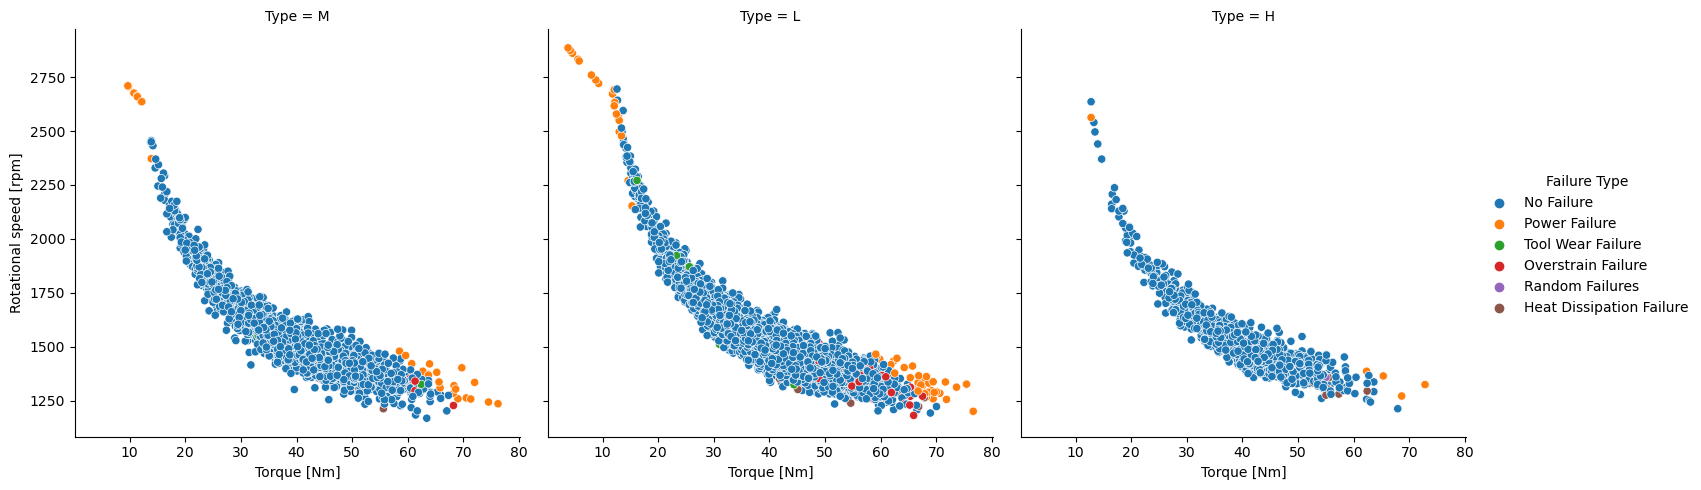

In [19]:
sns.relplot(data=df,x="Torque [Nm]", y="Rotational speed [rpm]", hue="Failure Type", col="Type")

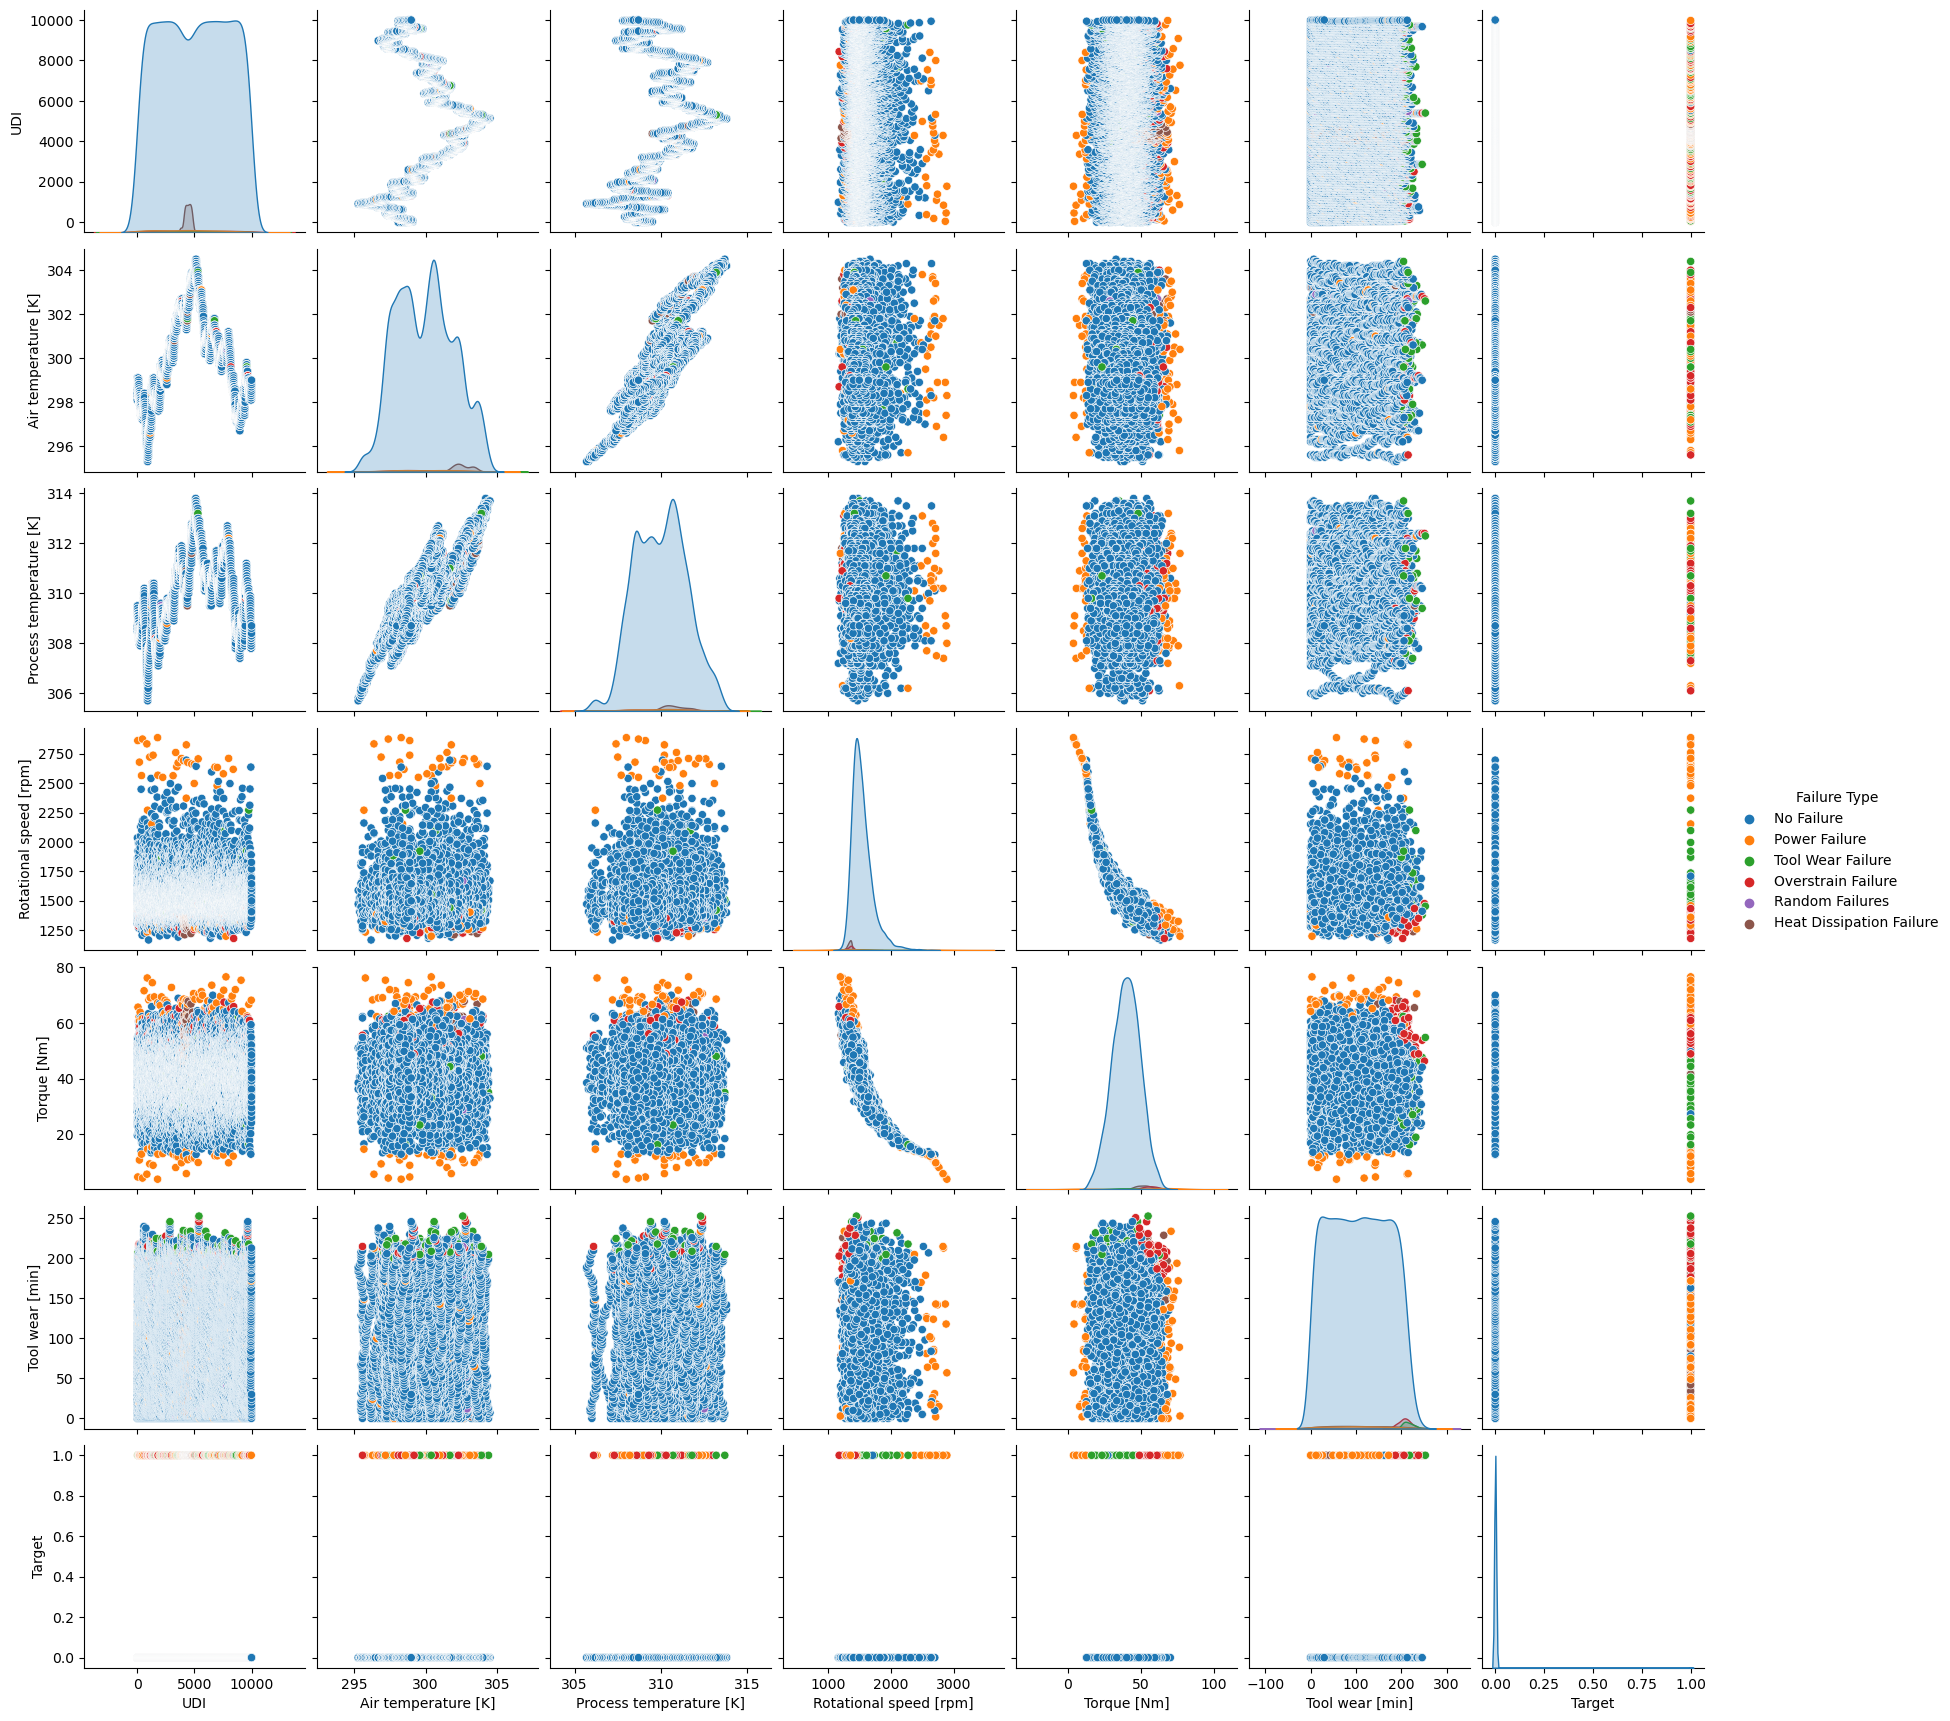

In [20]:
sns.pairplot(df,diag_kind='kde',hue='Failure Type') #it has histograms along the diagonal
                #scatterplots off the diagonal

### Data Preprocessing

In [21]:
new_data=df.copy()
scaler = LabelEncoder()
new_data['Type'] = scaler.fit_transform(new_data['Type'])
new_data['EncodedFailureType']= scaler.fit_transform(new_data['Failure Type'])

new_data=new_data.drop(columns=['UDI','Product ID'],axis=1)
new_data

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type,EncodedFailureType
0,2,298.1,308.6,1551,42.8,0,0,No Failure,1
1,1,298.2,308.7,1408,46.3,3,0,No Failure,1
2,1,298.1,308.5,1498,49.4,5,0,No Failure,1
3,1,298.2,308.6,1433,39.5,7,0,No Failure,1
4,1,298.2,308.7,1408,40.0,9,0,No Failure,1
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,0,No Failure,1
9996,0,298.9,308.4,1632,31.8,17,0,No Failure,1
9997,2,299.0,308.6,1645,33.4,22,0,No Failure,1
9998,0,299.0,308.7,1408,48.5,25,0,No Failure,1


### Splitting of dataset

In [23]:
X=new_data[independent_variables]
X

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9
...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14
9996,298.9,308.4,1632,31.8,17
9997,299.0,308.6,1645,33.4,22
9998,299.0,308.7,1408,48.5,25


In [22]:
y=new_data['EncodedFailureType']
y.unique()

array([1, 3, 5, 2, 4, 0])

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model training and evaluation with any hyperparameter passed or tuned

#### Logistic Regression

In [25]:
logistic_reg=LogisticRegression(random_state=1)
logistic_reg.fit(X_train,y_train)
y_pred_lr=logistic_reg.predict(X_test)

#Score returns the mean accuracy on the given test data and labels.
lr_train_accuracy=round(logistic_reg.score(X_train,y_train)*100,2)
lr_test_accuracy=round(accuracy_score(y_test,y_pred_lr)*100,2)
print("Logistic Regression Training Accuracy :",lr_train_accuracy,"%")
print("Logistic Regression Test Accuracy :",lr_test_accuracy,"%")

Logistic Regression Training Accuracy : 96.41 %
Logistic Regression Test Accuracy : 96.97 %


c:\Users\subhi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Decision Tree

In [26]:
decision_tree=DecisionTreeClassifier(random_state=1)

decision_tree.fit(X_train,y_train)
y_pred_dt=decision_tree.predict(X_test)

dt_train_accuracy= round(decision_tree.score(X_train, y_train) * 100, 2)
dt_test_accuracy = round(accuracy_score(y_test,y_pred_dt) * 100, 2)

print("Training Accuracy :",dt_train_accuracy ,"%")
print("Model Accuracy Score :",dt_test_accuracy ,"%")


Training Accuracy : 100.0 %
Model Accuracy Score : 97.7 %


#### Random Forest

In [27]:
random_forest = RandomForestClassifier(random_state=1)

random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)

rf_train_accuracy= round(random_forest.score(X_train, y_train) * 100, 2)
rf_test_accuracy = round(accuracy_score(y_test,y_pred_rf) * 100, 2)

print("Training Accuracy :",rf_train_accuracy ,"%")
print("Model Accuracy Score :",rf_test_accuracy ,"%")

Training Accuracy : 100.0 %
Model Accuracy Score : 98.37 %


#### SVC

In [28]:
svc=SVC(random_state=1)
svc.fit(X_train, y_train)
y_pred_svc=svc.predict(X_test)

svc_train_accuracy=round(svc.score(X_train, y_train) * 100, 2)
svc_test_accuracy=round(accuracy_score(y_test,y_pred_svc) * 100, 2)

print("Training Accuracy :",svc_train_accuracy ,"%")
print("Model Accuracy Score :",svc_test_accuracy ,"%")



Training Accuracy : 96.54 %
Model Accuracy Score : 96.83 %


#### XGBoost

### Post pruning a decision tree

[Text(0.6018715589314845, 0.9782608695652174, 'x[3] <= 64.95\ngini = 0.07\nsamples = 7000\nvalue = [89, 6749, 56, 64, 11, 31]'),
 Text(0.25268275897226755, 0.9347826086956522, 'x[3] <= 13.15\ngini = 0.06\nsamples = 6955\nvalue = [86, 6741, 51, 35, 11, 31]'),
 Text(0.026101141924959218, 0.8913043478260869, 'x[1] <= 313.3\ngini = 0.165\nsamples = 22\nvalue = [0, 2, 0, 20, 0, 0]'),
 Text(0.01957585644371941, 0.8478260869565217, 'x[1] <= 308.2\ngini = 0.091\nsamples = 21\nvalue = [0, 1, 0, 20, 0, 0]'),
 Text(0.013050570962479609, 0.8043478260869565, 'x[1] <= 308.05\ngini = 0.375\nsamples = 4\nvalue = [0, 1, 0, 3, 0, 0]'),
 Text(0.0065252854812398045, 0.7608695652173914, 'gini = 0.0\nsamples = 3\nvalue = [0, 0, 0, 3, 0, 0]'),
 Text(0.01957585644371941, 0.7608695652173914, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0, 0]'),
 Text(0.026101141924959218, 0.8043478260869565, 'gini = 0.0\nsamples = 17\nvalue = [0, 0, 0, 17, 0, 0]'),
 Text(0.03262642740619902, 0.8478260869565217, 'gini = 0.0\n

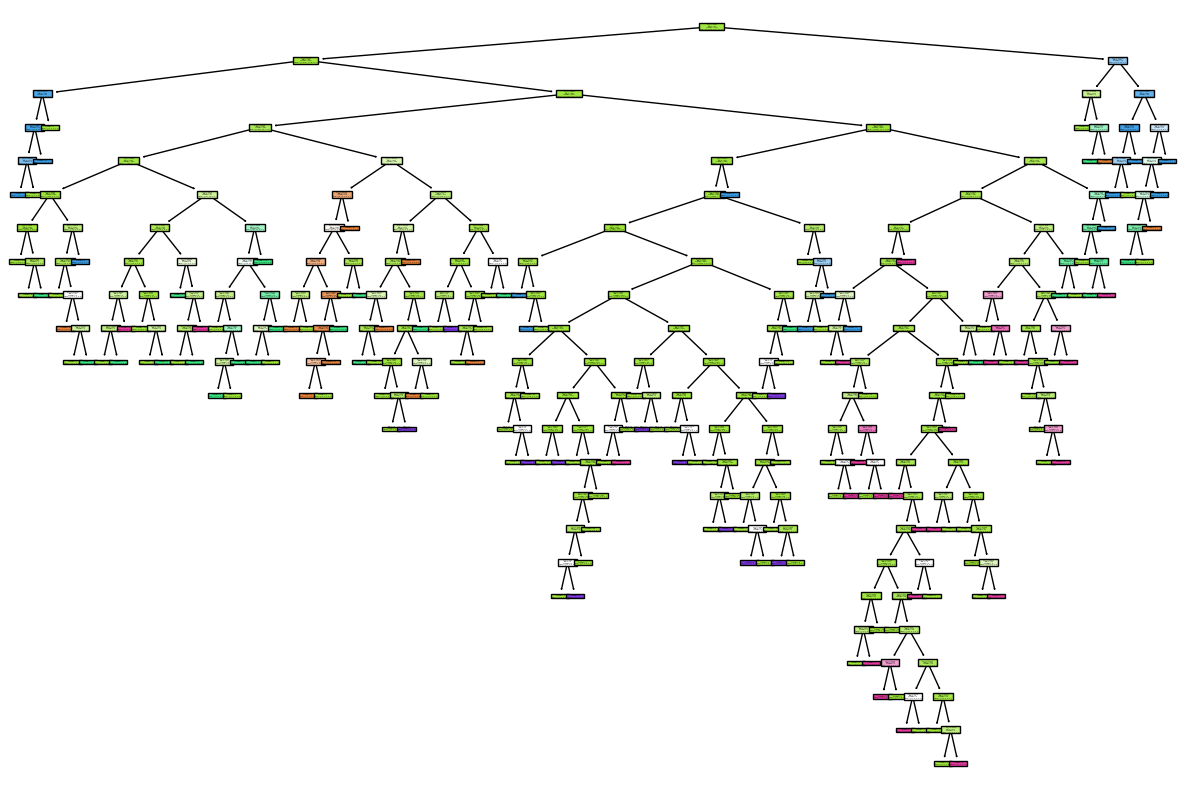

In [29]:
from sklearn import tree
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)

In [30]:
path=decision_tree.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas,impurities=path.ccp_alphas,path.impurities
ccp_alphas

array([0.00000000e+00, 5.71287895e-05, 8.54458694e-05, 8.92219728e-05,
       1.07142857e-04, 1.23809524e-04, 1.28571429e-04, 1.31868132e-04,
       1.34768428e-04, 1.36054422e-04, 1.37142857e-04, 1.38095238e-04,
       1.39225182e-04, 1.39455782e-04, 1.40435835e-04, 1.42610837e-04,
       1.46884055e-04, 1.67281106e-04, 1.75862614e-04, 1.78559367e-04,
       1.78571429e-04, 1.78571429e-04, 1.90041199e-04, 1.90476190e-04,
       1.90476190e-04, 1.90476190e-04, 1.90476190e-04, 1.90476190e-04,
       1.90476190e-04, 1.94581385e-04, 2.14285714e-04, 2.14285714e-04,
       2.14285714e-04, 2.28571429e-04, 2.32142857e-04, 2.38080984e-04,
       2.43506494e-04, 2.46467818e-04, 2.47371676e-04, 2.50000000e-04,
       2.53968254e-04, 2.54007019e-04, 2.60461760e-04, 2.63736264e-04,
       2.66666667e-04, 2.71211275e-04, 2.83549784e-04, 3.04241503e-04,
       3.09090909e-04, 3.29670330e-04, 3.64285714e-04, 3.70748299e-04,
       3.79027604e-04, 3.96274912e-04, 3.98874459e-04, 4.09297052e-04,
      

In [31]:
dts=[]
for ccp_alpha in ccp_alphas:
    decision_tree=DecisionTreeClassifier(random_state=1,ccp_alpha=ccp_alpha)
    decision_tree.fit(X_train,y_train)
    dts.append(decision_tree)
# print("Number of ")

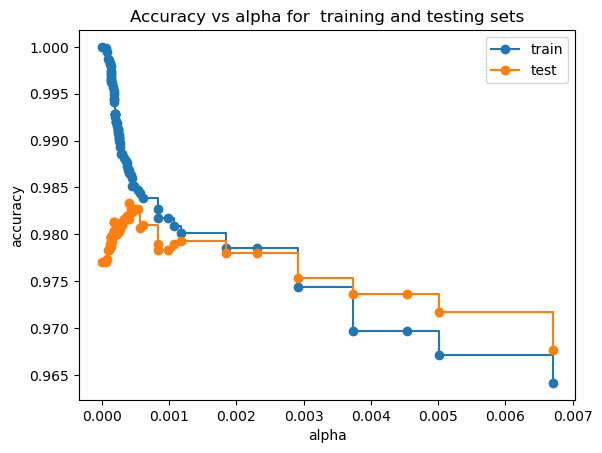

In [32]:
train_scores=[decision_tree.score(X_train,y_train) for decision_tree in dts]
test_scores=[decision_tree.score(X_test,y_test) for decision_tree in dts]

fig,ax=plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for  training and testing sets")
ax.plot(ccp_alphas, train_scores,marker="o",label="train",drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores,marker="o",label="test",drawstyle="steps-post")
plt.legend()
plt.show()

In [37]:
decision_tree=DecisionTreeClassifier(random_state=1,ccp_alpha=0.0012)
decision_tree.fit(X_train,y_train)
y_pred_dt=decision_tree.predict(X_test)

dt_train_accuracy= round(decision_tree.score(X_train, y_train) * 100, 2)
dt_test_accuracy = round(accuracy_score(y_test,y_pred_dt) * 100, 2)

print("Training Accuracy :",dt_train_accuracy ,"%")
print("Model Accuracy Score :",dt_test_accuracy ,"%")


Training Accuracy : 98.01 %
Model Accuracy Score : 97.93 %


[Text(0.5555555555555556, 0.9375, 'x[3] <= 64.95\ngini = 0.07\nsamples = 7000\nvalue = [89, 6749, 56, 64, 11, 31]'),
 Text(0.4444444444444444, 0.8125, 'x[3] <= 13.15\ngini = 0.06\nsamples = 6955\nvalue = [86, 6741, 51, 35, 11, 31]'),
 Text(0.3333333333333333, 0.6875, 'gini = 0.165\nsamples = 22\nvalue = [0, 2, 0, 20, 0, 0]'),
 Text(0.5555555555555556, 0.6875, 'x[2] <= 1380.5\ngini = 0.055\nsamples = 6933\nvalue = [86, 6739, 51, 15, 11, 31]'),
 Text(0.4444444444444444, 0.5625, 'x[0] <= 301.55\ngini = 0.252\nsamples = 936\nvalue = [86, 804, 38, 4, 2, 2]'),
 Text(0.2222222222222222, 0.4375, 'x[4] <= 188.5\ngini = 0.107\nsamples = 698\nvalue = [2, 659, 31, 4, 0, 2]'),
 Text(0.1111111111111111, 0.3125, 'gini = 0.026\nsamples = 606\nvalue = [2, 598, 2, 4, 0, 0]'),
 Text(0.3333333333333333, 0.3125, 'x[3] <= 53.75\ngini = 0.461\nsamples = 92\nvalue = [0, 61, 29, 0, 0, 2]'),
 Text(0.2222222222222222, 0.1875, 'gini = 0.229\nsamples = 55\nvalue = [0, 48, 5, 0, 0, 2]'),
 Text(0.4444444444444444, 0

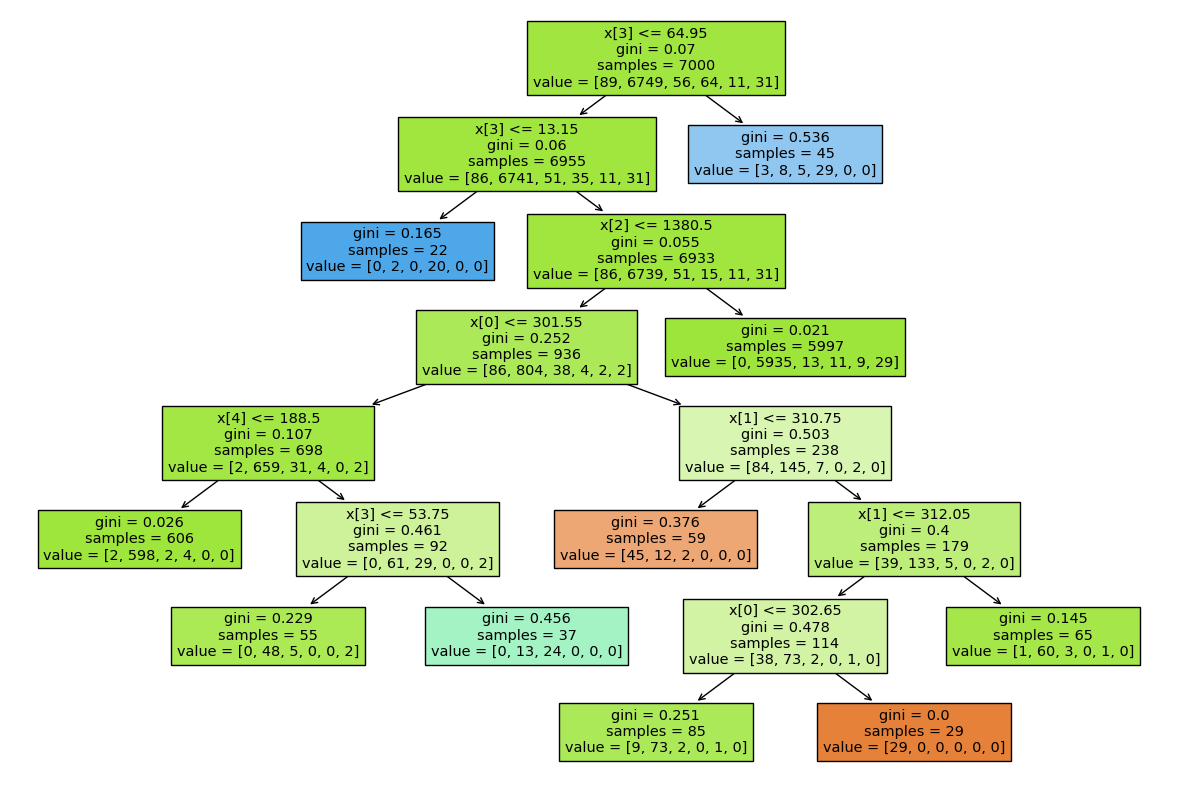

In [38]:
plt.figure(figsize=(15,10))
tree.plot_tree(decision_tree,filled=True)

### Hyperparameter tuning using GridSearchCV
Don't run this section again and again, run once and store the results in a session and access later

In [39]:
# Define model parameters
model_params = {
    'dt':{'model':DecisionTreeClassifier(criterion='gini',random_state=1,ccp_alpha=0.0012),
          'params':{'max_depth':[5,6,7,8,10,20,30,50],'min_samples_split':[50,100,200],'min_samples_leaf':[50,100,200]}
          },
    'svc': {'model': SVC(gamma='auto',random_state=1),
        'params': {'C': [1, 10, 20], 'kernel': ['rbf']}
            },
    'random_forest': {'model': RandomForestClassifier(criterion='gini',random_state=1),
        'params': {'n_estimators': [10, 50, 100],'max_depth':[8,10,20,30,50],'min_samples_split':[50,100,200],'min_samples_leaf':[50,100,200]}
            },
    'logistic_regression': {'model': LogisticRegression(penalty='l2',random_state=1),
        'params': {'C': [1, 5, 10]}
            }
}

# Perform grid search and store results
scores = []
for model_name, mp in model_params.items():
    print(model_name)
    print(mp)
    classifier = GridSearchCV(mp['model'], mp['params'], cv=10, return_train_score=True)
    classifier.fit(X.values, y.values)
    scores.append({
        'model': model_name,
        'best_score': classifier.best_score_,
        'best_params': classifier.best_params_,
        'mean_train_score': np.mean(classifier.cv_results_['mean_train_score']),
            })
    print(scores)

# Create DataFrame from scores
df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params', 'mean_train_score'])

# Print the results
df


dt
{'model': DecisionTreeClassifier(ccp_alpha=0.0012, random_state=1), 'params': {'max_depth': [5, 6, 7, 8, 10, 20, 30, 50], 'min_samples_split': [50, 100, 200], 'min_samples_leaf': [50, 100, 200]}}
[{'model': 'dt', 'best_score': 0.9692000000000001, 'best_params': {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': 0.9687966049382715}]
svc
{'model': SVC(gamma='auto', random_state=1), 'params': {'C': [1, 10, 20], 'kernel': ['rbf']}}
[{'model': 'dt', 'best_score': 0.9692000000000001, 'best_params': {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': 0.9687966049382715}, {'model': 'svc', 'best_score': 0.9652, 'best_params': {'C': 1, 'kernel': 'rbf'}, 'mean_train_score': 0.9988407407407407}]
random_forest
{'model': RandomForestClassifier(random_state=1), 'params': {'n_estimators': [10, 50, 100], 'max_depth': [8, 10, 20, 30, 50], 'min_samples_split': [50, 100, 200], 'min_samples_leaf': [50, 100, 200]}}
[{'model': 'dt', 'b

c:\Users\subhi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\subhi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

[{'model': 'dt', 'best_score': 0.9692000000000001, 'best_params': {'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}, 'mean_train_score': 0.9687966049382715}, {'model': 'svc', 'best_score': 0.9652, 'best_params': {'C': 1, 'kernel': 'rbf'}, 'mean_train_score': 0.9988407407407407}, {'model': 'random_forest', 'best_score': 0.9658, 'best_params': {'max_depth': 8, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 10}, 'mean_train_score': 0.9654180246913581}, {'model': 'logistic_regression', 'best_score': 0.9662, 'best_params': {'C': 5}, 'mean_train_score': 0.9661518518518518}]


,model,best_score,best_params,mean_train_score
0,dt,0.9692,"{'max_depth': 7, 'min_samples_leaf': 50, 'min_...",0.968797
1,svc,0.9652,"{'C': 1, 'kernel': 'rbf'}",0.998841
2,random_forest,0.9658,"{'max_depth': 8, 'min_samples_leaf': 50, 'min_...",0.965418
3,logistic_regression,0.9662,{'C': 5},0.966152


In [40]:
%store scores

Stored 'scores' (list)


### Models initialization using set of best parameters achieved using GridSearchCV


In [41]:
%store -r scores

In [42]:
scores[0]['best_params']

{'max_depth': 7, 'min_samples_leaf': 50, 'min_samples_split': 50}

In [43]:
scores[2]['best_params']['n_estimators'],

(10,)

In [44]:
decision_tree=DecisionTreeClassifier(criterion='gini', ccp_alpha=0.0015,random_state=1,max_depth=scores[0]['best_params']['max_depth'],
                                     min_samples_leaf=scores[0]['best_params']['min_samples_leaf'],
                                     min_samples_split=scores[0]['best_params']['min_samples_split'])

svc=SVC(gamma='auto',random_state=1,C=scores[1]['best_params']['C'],kernel=scores[1]['best_params']['kernel'])

random_forest=RandomForestClassifier(criterion='gini',random_state=1,max_depth=scores[2]['best_params']['max_depth'],
                                     n_estimators=scores[2]['best_params']['n_estimators'],
                                     min_samples_leaf=scores[2]['best_params']['min_samples_leaf'],
                                     min_samples_split=scores[2]['best_params']['min_samples_split'])

logistic_reg=LogisticRegression(penalty='l2',random_state=1,C=scores[3]['best_params']['C'])

### Using Stratified K-Fold Cross Validation for Model Training and Evaluation 

In [45]:
def get_score(model, stratified_kfold):
    cv_results = cross_validate(model, X, y, cv=stratified_kfold, return_train_score=True)

    print("****" * 4)
    print(model)
    print('Train Scores:', cv_results['train_score'])
    print('Test Scores:', cv_results['test_score'])
    print('Average Train Accuracy:', np.mean(cv_results['train_score']))
    print('Average Test Accuracy:', np.mean(cv_results['test_score']))
    print("****" * 4)

models=[svc,logistic_reg,decision_tree,random_forest]
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for model in models:
    get_score(model,stratified_kfold)

****************
SVC(C=1, gamma='auto', random_state=1)
Train Scores: [0.99655556 0.99666667 0.99666667 0.99622222 0.99677778 0.99633333
 0.99666667 0.99655556 0.99622222 0.99611111]
Test Scores: [0.966 0.966 0.965 0.965 0.965 0.965 0.965 0.965 0.965 0.965]
Average Train Accuracy: 0.9964777777777778
Average Test Accuracy: 0.9652
****************


c:\Users\subhi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\subhi\anaconda3\envs\tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

****************
LogisticRegression(C=5, random_state=1)
Train Scores: [0.96822222 0.96711111 0.96655556 0.96566667 0.96555556 0.96788889
 0.96655556 0.96877778 0.96511111 0.96577778]
Test Scores: [0.964 0.966 0.967 0.965 0.967 0.965 0.968 0.965 0.971 0.964]
Average Train Accuracy: 0.9667222222222221
Average Test Accuracy: 0.9662000000000001
****************
****************
DecisionTreeClassifier(ccp_alpha=0.0015, max_depth=7, min_samples_leaf=50,
                       min_samples_split=50, random_state=1)
Train Scores: [0.97211111 0.97666667 0.97533333 0.97544444 0.97555556 0.97477778
 0.97544444 0.97477778 0.97544444 0.975     ]
Test Scores: [0.973 0.973 0.976 0.973 0.975 0.979 0.977 0.972 0.972 0.97 ]
Average Train Accuracy: 0.9750555555555556
Average Test Accuracy: 0.974
****************
****************
RandomForestClassifier(max_depth=8, min_samples_leaf=50, min_samples_split=50,
                       n_estimators=10, random_state=1)
Train Scores: [0.96788889 0.96511111 0.9652